# Unsupervised graph classification/representation learning via distances

This demo demonstrated training a graph classification model without supervision. This model could be used to compute embedding vectors or representations for graphs.

The algorithm uses a ground-truth distance between graphs as a metric to train against, by embedding pairs of graphs simultaneously and combining the resulting embedding vectors to match the distance.

It is inspired by UGraphEmb[1].

[1]: Y. Bai et al., “Unsupervised Inductive Graph-Level Representation Learning via Graph-Graph Proximity,” [arXiv:1904.01098](http://arxiv.org/abs/1904.01098) [cs, stat], Jun. 2019.

In [95]:
import stellargraph as sg
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras

## Dataset

The PROTEINS dataset consists of about one thousand graphs, with binary labels `1` or `2`.

In [96]:
dataset = sg.datasets.PROTEINS()
graphs, graph_labels = dataset.load()

In [97]:
dataset.description

'Each graph represents a protein and graph labels represent whether they are are enzymes or non-enzymes. The dataset includes 1113 graphs with 39 nodes and 73 edges on average for each graph. Graph nodes have 4 attributes (including a one-hot encoding of their label), and each graph is labelled as belonging to 1 of 2 classes.'

In [98]:
g = graphs[0]

In [99]:
g.node_features().shape

(42, 4)

In [100]:
len(graphs)

1113

In [101]:
graph_labels.value_counts().to_frame()

,label
1,663
2,450


The `graphs` value consists of many `StellarGraph` instances:

In [102]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


Summary statistics of the sizes of the graphs:

In [103]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1113.0,1113.0
mean,39.1,145.6
std,45.8,169.3
min,4.0,10.0
25%,15.0,56.0
50%,26.0,98.0
75%,45.0,174.0
max,620.0,2098.0


## Create the model

In [104]:
generator = sg.mapper.PaddedGraphGenerator(graphs)

In [105]:
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [106]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [107]:
pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

## Train the model

The model is trained on 100 random pairs of graphs, along with the ground-truth distance between them.

### Similarity measure

This method can use any notion of distance or similarity between two graphs. In this case, we use something efficient, but not particularly accurate: the distance between the spectrum (or eigenvalues) of the [Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix) of the graphs.

Other options include graph edit distance and minimum common subgraph, but these are NP-hard to compute and are too slow for this demonstration.

In [108]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

### Training examples

In [109]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))

In [110]:
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]

In [111]:
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

### Training procedure

In [112]:
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

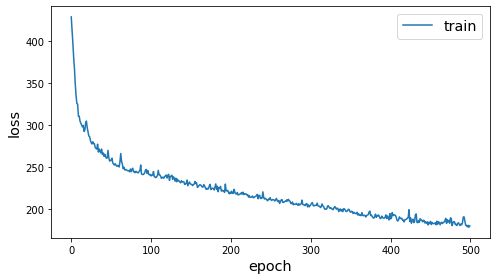

In [113]:
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

In [119]:
type(embeddings)

numpy.ndarray

## Compute embeddings

In [114]:
embeddings = embedding_model.predict(generator.flow(graphs))

In [115]:
embeddings.shape

(1113, 96)

## Downstream tasks

Now that we've computed some embedding vectors in an unsupervised fashion, we can use them for other supervised, semi-supervised and unsupervised tasks.

### Supervised graph classification

We can use the embedding vectors to perform logistic regression classification, using the labels.

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [117]:
train_labels, test_labels = model_selection.train_test_split(
    graph_labels, train_size=0.1, test_size=None, stratify=graph_labels
)

test_embeddings = embeddings[test_labels.index - 1]
train_embeddings = embeddings[train_labels.index - 1]

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_labels)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_labels).mean()
print(f"Test classification accuracy: {gcn_acc}")

AttributeError: 'str' object has no attribute 'decode'

#### Confusion matrix

In [ ]:
pd.crosstab(test_labels, y_pred, rownames=["true"], colnames=["predicted"])

### Visualising embeddings

We can also get a qualitative measure of the embeddings, using dimensionality reduction.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)

## Conclusion

This demo demonstrated training a graph classification model without supervision. This model could be used to compute embedding vectors or representations for graphs. 

The algorithm works with three components:

- a ground truth distance or similarity between two graphs such as graph edit distance, or, in this case, Laplacian spectrum distance (for efficiency)
- a model that encodes graphs into embedding vectors
- a data generator that yields pairs of graphs and the corresponding ground truth distance

This model is inspired by UGraphEmb[1].

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/gcn-unsupervised-graph-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/gcn-unsupervised-graph-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>